**IMPORTING REQUIRED LIBRARIES**

In [43]:
# Importing necessary libraries
import pandas as pd

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**LOADING DATA**

In [14]:
# Load the dataset
data = pd.read_csv('/content/news.csv')

# Display the first few rows of the dataset
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


**BASIC DATA ANALYSIS**

In [4]:
data.shape

(6335, 4)

In [3]:
data.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [17]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

,0
title,0
text,0
label,0


In [8]:
data.label.value_counts()

,count
label,
REAL,3171
FAKE,3164


In [10]:
data.describe(include='object')

,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


**CLEANING DATA**

In [19]:
# Drop the 'Unnamed: 0' column
#This column seems to be an index column, likely created during data export. We can ignore or drop it.
data = data.drop(columns=['Unnamed: 0'])
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


No Missing Values: There are no missing values in the dataset, which means we don't need to handle any gaps or empty entries.

Balanced Dataset: The dataset is quite balanced, with 3,171 "REAL" news articles and 3,164 "FAKE" news articles. This is good because a balanced dataset usually helps in building a model that doesn’t favor one class over the other.

**TEXT PREPROCESSING**

This step is crucial because machine learning models require numerical input, so we need to convert our text data into a numerical format.


*Preprocessing Tasks:*

Lowercasing: Convert all text to lowercase to maintain uniformity.
Removing

Punctuation: Punctuation marks do not contribute to the meaning in a significant way for our model.

Tokenization: Splitting text into words.

Removing Stopwords: Common words like "the", "and", "is", etc., that don’t add much meaning.

Lemmatization: Reducing words to their base or root form.

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    return ' '.join(words)

# Apply preprocessing to the 'text' column
data['processed_text'] = data['text'].apply(preprocess_text)

# Display the first few rows of the dataset to see the changes
data[['text', 'processed_text']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,processed_text
0,"Daniel Greenfield, a Shillman Journalism Fello...",daniel greenfield shillman journalism fellow f...
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,google pinterest digg linkedin reddit stumbleu...
2,U.S. Secretary of State John F. Kerry said Mon...,us secretary state john f kerry said monday st...
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",— kaydee king kaydeeking november 9 2016 lesso...
4,It's primary day in New York and front-runners...,primary day new york frontrunners hillary clin...


**Step 5: Text Vectorization using TF-IDF**

 we need to convert it into a numerical format that the machine learning model can understand. We will use TF-IDF Vectorization for this purpose.

 TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

Term Frequency (TF): How frequently a term occurs in a document.
Inverse Document Frequency (IDF): Measures how important a term is across all documents.

The result is a value that balances both frequency and rarity, making it useful for text classification.

In [24]:


# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the processed text
X = tfidf_vectorizer.fit_transform(data['processed_text'])

# Convert labels to binary (0 for REAL, 1 for FAKE)
y = data['label'].apply(lambda x: 1 if x == 'FAKE' else 0)

# Display the shape of the resulting vector
print('Input data text shape is :',X.shape)


Input data text shape is : (6335, 5000)


**STEP 5 INFERENCE :**

we have successfully transformed our text data into a TF-IDF matrix with 6,335 documents (news articles) and 5,000 features (terms).

 This matrix is now ready to be used as input for our machine learning model.

**Step 6: Building the LSTM Model**

LSTM (Long Short-Term Memory) networks are a type of Recurrent Neural Network (RNN) that are particularly effective for tasks where the order of the information is important, such as text classification.

Handles Sequential Data: LSTMs are well-suited for sequential data, where the order of words matters.

Memory Retention: LSTMs can retain information over long sequences, helping in understanding the context better.

In [36]:


# Initialize the tokenizer with a maximum number of words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['processed_text'])

# Convert text to sequences of integers
X_sequences = tokenizer.texts_to_sequences(data['processed_text'])

# Pad the sequences to ensure uniform length
X_padded = pad_sequences(X_sequences, maxlen=500)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


In [40]:
# Building the LSTM model
model = Sequential()

# Adding an embedding layer (no need for input_length now)
model.add(Embedding(input_dim=5000, output_dim=128))

# Adding a Spatial Dropout layer
model.add(SpatialDropout1D(0.2))

# Adding the LSTM layer
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Adding a Dense output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [39]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {score[0]} / Test Accuracy: {score[1]}')


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6535 - loss: 0.6087 - val_accuracy: 0.8879 - val_loss: 0.2854
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9128 - loss: 0.2458 - val_accuracy: 0.8792 - val_loss: 0.2833
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9456 - loss: 0.1625 - val_accuracy: 0.9013 - val_loss: 0.2536
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9518 - loss: 0.1429 - val_accuracy: 0.8769 - val_loss: 0.3004
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9713 - loss: 0.0946 - val_accuracy: 0.8832 - val_loss: 0.3230
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8640 - loss: 0.3534
Test Loss: 0.3229658305644989 / Test Accuracy: 0.8831886053085327


**Fine-Tuning the model :**

SpatialDropout1D(0.3): Increased dropout from 0.2 to 0.3 to further regularize the model.

LSTM(100, dropout=0.3, recurrent_dropout=0.3): Increased dropout rates in the LSTM layer to 0.3 for both regular and recurrent units.

Adam(learning_rate=0.0005): Reduced the learning rate, which might help the model converge more slowly but potentially more effectively.

In [42]:
# Rebuild the fine-tuned model
fine_tuned_model = Sequential()

# Embedding layer
fine_tuned_model.add(Embedding(input_dim=5000, output_dim=128))

# Adjusted Spatial Dropout layer
fine_tuned_model.add(SpatialDropout1D(0.3))  # Increased dropout from 0.2 to 0.3

# Adjusted LSTM layer
fine_tuned_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))  # Increased dropout from 0.2 to 0.3

# Dense output layer
fine_tuned_model.add(Dense(1, activation='sigmoid'))

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0005)  # Decreased learning rate from default 0.001 to 0.0005

# Compile the fine-tuned model with the new optimizer
fine_tuned_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the fine-tuned model
history_fine_tuned = fine_tuned_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the fine-tuned model on the test data
score_fine_tuned = fine_tuned_model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {score_fine_tuned[0]} / Test Accuracy: {score_fine_tuned[1]}')


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6251 - loss: 0.6729 - val_accuracy: 0.8390 - val_loss: 0.4275
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8631 - loss: 0.3667 - val_accuracy: 0.8934 - val_loss: 0.2937
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9167 - loss: 0.2639 - val_accuracy: 0.9227 - val_loss: 0.2148
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9369 - loss: 0.1899 - val_accuracy: 0.8769 - val_loss: 0.3028
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9361 - loss: 0.1912 - val_accuracy: 0.9092 - val_loss: 0.2571
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9079 - loss: 0.2763
Test Loss: 0.2571094036102295 / Test Accuracy: 0.9092344045639038


**Original Model (with Default Settings):**

Test Accuracy: **88.32%**

Test Loss: **0.3230**



 **Fine-Tuned Model (with Adjusted Dropout and Learning Rate):**

Test Accuracy: **90.92%**

Test Loss: **0.2571**


Key Observations:

**Improved Accuracy**: The test accuracy increased from 88.32% to 90.92%. This indicates that the fine-tuned model is better at distinguishing between "FAKE" and "REAL" news.


**Reduced Loss:** The test loss decreased from 0.3230 to 0.2571, suggesting that the model's predictions are more confident and the overall performance has improved.


**MODEL EVALUATION :**

In [45]:
# Predicting the labels for the test set
#If the probability is greater than 0.5, the model predicts the positive class ("FAKE").
y_pred = (fine_tuned_model.predict(X_test) > 0.5).astype("int32") #Threshold of 0.5

# Generating a classification report
report = classification_report(y_test, y_pred, target_names=['REAL', 'FAKE'])
print(report)

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step
              precision    recall  f1-score   support

        REAL       0.92      0.90      0.91       639
        FAKE       0.90      0.92      0.91       628

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



array([[575,  64],
       [ 51, 577]])

**Overall Interpretation:**


**Balanced Performance:** The model performs well for both classes with high Precision, Recall, and F1-Scores close to **0.91** for both "REAL" and "FAKE" classes.

 **False Positives and False Negatives:** The model makes some errors, with **64** false positives (misclassifying "REAL" news as "FAKE") and **51** false negatives (misclassifying "FAKE" news as "REAL"). However, these errors are **relatively small** compared to the total number of instances.


**High Accuracy:** An overall accuracy of **91% is strong**, indicating that the model is effective in distinguishing between fake and real news.

# **VISUALIZING THE RESULTS**

## **1. Distribution of Classes (FAKE vs. REAL)**


<ipython-input-46-eeac417a8e7a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


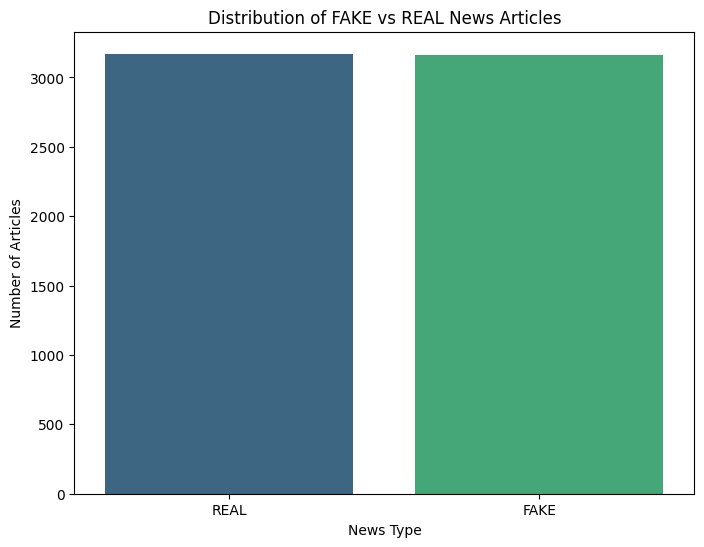

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of instances for each class
class_counts = data['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of FAKE vs REAL News Articles')
plt.xlabel('News Type')
plt.ylabel('Number of Articles')
plt.show()


## **2. Word Cloud for Most Common Words**

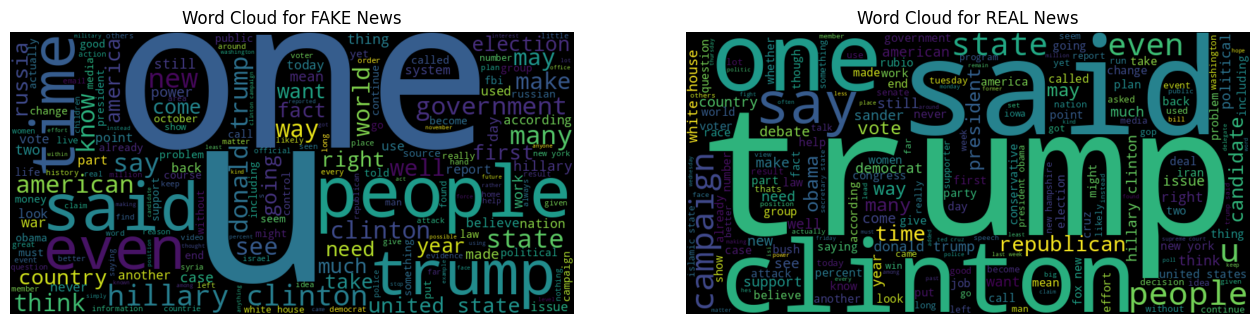

In [47]:
from wordcloud import WordCloud

# Generate word clouds for FAKE news
fake_news_text = ' '.join(data[data['label'] == 'FAKE']['processed_text'])
fake_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(fake_news_text)

# Generate word clouds for REAL news
real_news_text = ' '.join(data[data['label'] == 'REAL']['processed_text'])
real_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(real_news_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))

# FAKE news word cloud
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for FAKE News')
plt.axis('off')

# REAL news word cloud
plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for REAL News')
plt.axis('off')

plt.show()


## **3. Confusion Matrix Heatmap**

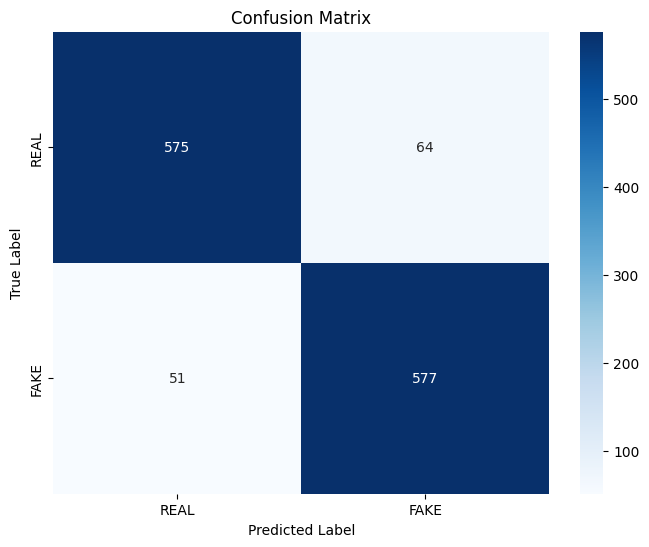

In [48]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Inference from the Confusion Matrix:**


**True Positives (Bottom Right - 577):**

The model correctly predicted 577 instances as "FAKE" when they were indeed "FAKE." This is a strong indication that the model is effective at identifying fake news.

**True Negatives (Top Left - 575):**

The model correctly predicted 575 instances as "REAL" when they were indeed "REAL." This shows that the model is also quite good at recognizing real news.

**False Positives (Top Right - 64):**

The model incorrectly predicted 64 instances as "FAKE" when they were actually "REAL." These are instances where the model falsely flagged real news as fake. The relatively small number of false positives suggests that the model does not have a high false alarm rate, which is desirable.

**False Negatives (Bottom Left - 51):**

The model incorrectly predicted 51 instances as "REAL" when they were actually "FAKE." These are cases where the model missed identifying fake news. While this number is also relatively small, it indicates there is some room for improvement in capturing all instances of fake news.

**Key Takeaways:**

**High Accuracy in Both Classes:** The model performs well in both detecting fake news and correctly identifying real news, as indicated by the high numbers in the true positive (577) and true negative (575) cells.

**Balanced Errors:** The number of false positives (64) and false negatives (51) is relatively balanced, which indicates that the model is not significantly biased toward one class over the other.

**Overall Model Performance:** The confusion matrix reflects a model that is quite robust, with a high overall accuracy and balanced performance across both classes.

## **4. Precision-Recall Curve**

**Purpose:** Understand the trade-off between precision and recall across different thresholds.

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step


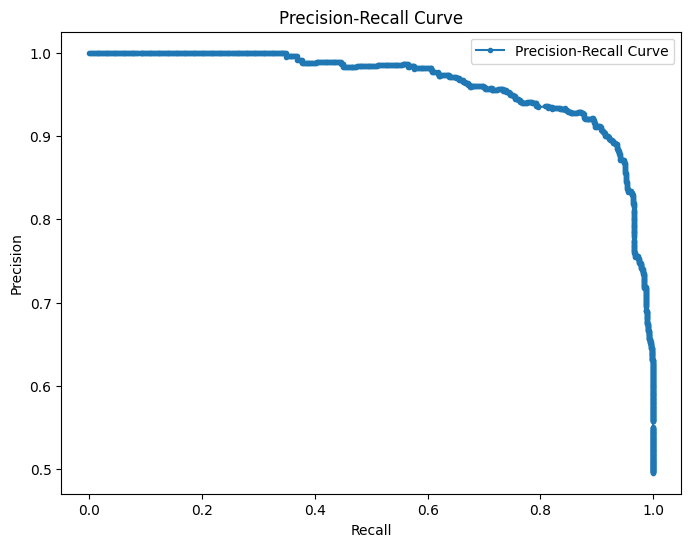

In [49]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_probs = fine_tuned_model.predict(X_test).ravel()

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


**Balanced Performance:**

The curve is relatively flat and close to 1.0 for a significant range of Recall values (from about 0 to 0.7), indicating that the model maintains high Precision even as it begins to capture more "FAKE" instances. This suggests a well-balanced model that can handle the trade-off between capturing most "FAKE" news (Recall) while still maintaining a high level of accuracy in those predictions (Precision).

## **5. Distribution of Text Length**

<ipython-input-50-7850dfd7eb82>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=data, palette='Set2')


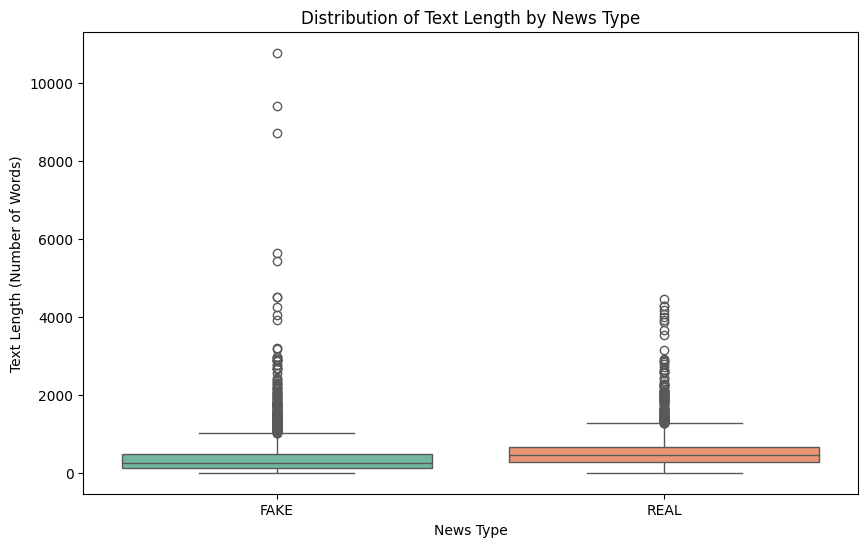

In [50]:
# Calculate the length of each article
data['text_length'] = data['processed_text'].apply(lambda x: len(x.split()))

# Create a box plot to visualize the distribution of text lengths for each class
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=data, palette='Set2')
plt.title('Distribution of Text Length by News Type')
plt.xlabel('News Type')
plt.ylabel('Text Length (Number of Words)')
plt.show()


## **6. Most Common Words by Class**

<ipython-input-51-bafcd363093e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=fake_top_words_df, palette='Reds_d')
<ipython-input-51-bafcd363093e>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=real_top_words_df, palette='Blues_d')


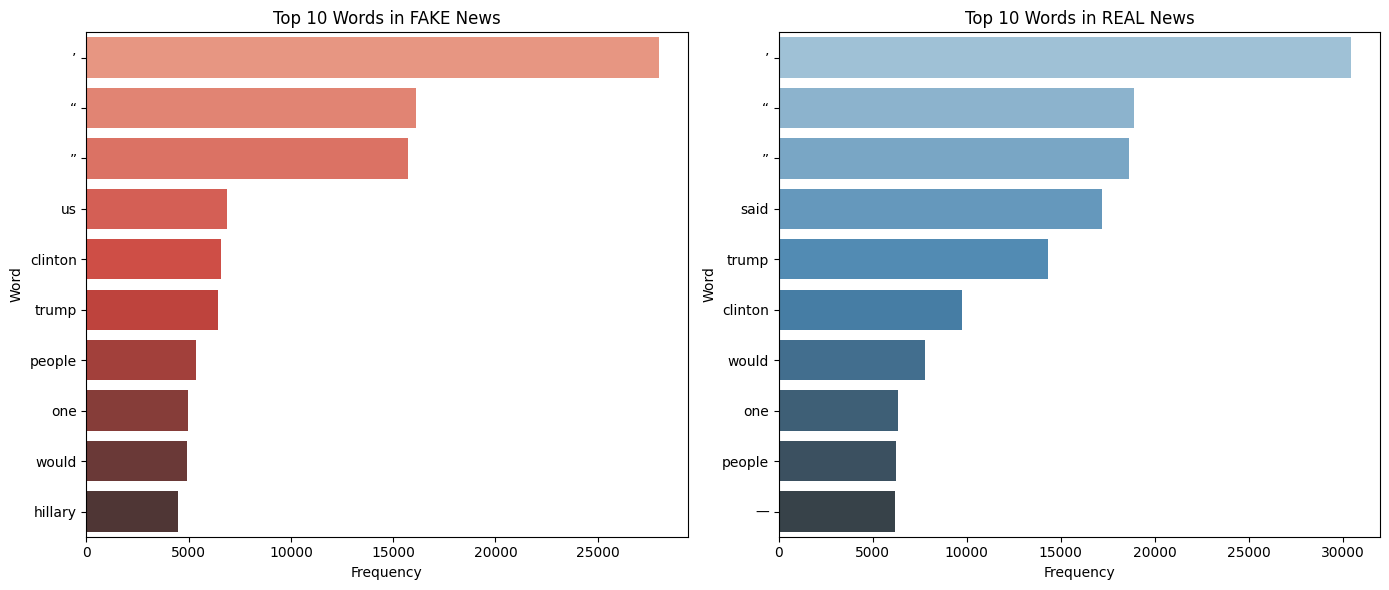

In [51]:
from collections import Counter

# Function to get top N words
def get_top_n_words(text, n=10):
    words = ' '.join(text).split()
    word_freq = Counter(words)
    return word_freq.most_common(n)

# Get top 10 words for FAKE news
fake_top_words = get_top_n_words(data[data['label'] == 'FAKE']['processed_text'], 10)

# Get top 10 words for REAL news
real_top_words = get_top_n_words(data[data['label'] == 'REAL']['processed_text'], 10)

# Convert to DataFrame for easy plotting
fake_top_words_df = pd.DataFrame(fake_top_words, columns=['Word', 'Frequency'])
real_top_words_df = pd.DataFrame(real_top_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=fake_top_words_df, palette='Reds_d')
plt.title('Top 10 Words in FAKE News')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=real_top_words_df, palette='Blues_d')
plt.title('Top 10 Words in REAL News')

plt.tight_layout()
plt.show()
